In [44]:
import datetime
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
url = "https://www.techpowerup.com/gpu-specs/"

In [3]:
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
# Taking all HTML content stored on site

In [4]:
#This finds too much, would like to narrow down the details
soup.find_all(class_="processors")

#Therefore we can't look for things by class or id.

[<table class="processors">
 <thead>
 <tr>
 <th class="mfgr" colspan="8" id="Popular">Popular</th>
 </tr>
 </thead>
 <thead class="colheader">
 <tr>
 <th>Product Name</th>
 <th>GPU Chip</th>
 <th>Released</th>
 <th>Bus</th>
 <th>Memory</th>
 <th>GPU clock</th>
 <th>Memory clock</th>
 <th>Shaders / TMUs / ROPs</th>
 </tr>
 </thead>
 <tr>
 <td class="vendor-NVIDIA">
 <a href="/gpu-specs/geforce-rtx-3060.c3682">GeForce RTX 3060</a>
 </td>
 <td>
 <a href="/gpu-specs/nvidia-ga106.g966">GA106</a>
 </td>
 <td>Jan 12th, 2021</td>
 <td>PCIe 4.0 x16</td>
 <td>12 GB, GDDR6, 192 bit</td>
 <td>1320 MHz</td>
 <td>1875 MHz</td>
 <td>3584 / 112 / 48</td>
 </tr>
 <tr>
 <td class="vendor-NVIDIA">
 <a href="/gpu-specs/geforce-rtx-3090.c3622">GeForce RTX 3090</a>
 </td>
 <td>
 <a href="/gpu-specs/nvidia-ga102.g930">GA102</a>
 </td>
 <td>Sep 1st, 2020</td>
 <td>PCIe 4.0 x16</td>
 <td>24 GB, GDDR6X, 384 bit</td>
 <td>1395 MHz</td>
 <td>1219 MHz</td>
 <td>10496 / 328 / 112</td>
 </tr>
 <tr>
 <td class="vendo

In [5]:
table = soup.findChildren('table')[1]
# Locates only the tables, where there are 2, I see the second one being the actual table needed for the data
headers = table.findChildren(['tr'])[1]
# Heading for each GPU, the name, type, date released, and in depth info.
headers

<tr>
<th>Product Name</th>
<th>GPU Chip</th>
<th>Released</th>
<th>Bus</th>
<th>Memory</th>
<th>GPU clock</th>
<th>Memory clock</th>
<th>Shaders / TMUs / ROPs</th>
</tr>

In [6]:
x = []
for i in table.find_all(['th'])[1:]:
    x.append(i.text.replace('\n', ' ').strip())
x

['Product Name',
 'GPU Chip',
 'Released',
 'Bus',
 'Memory',
 'GPU clock',
 'Memory clock',
 'Shaders / TMUs / ROPs']

In [7]:
y = []
for i in table.find_all("td"):
    y.append(i.text.replace('\n', ' ').strip())
y

['GeForce RTX 3060',
 'GA106',
 'Jan 12th, 2021',
 'PCIe 4.0 x16',
 '12 GB, GDDR6, 192 bit',
 '1320 MHz',
 '1875 MHz',
 '3584 / 112 / 48',
 'GeForce RTX 3090',
 'GA102',
 'Sep 1st, 2020',
 'PCIe 4.0 x16',
 '24 GB, GDDR6X, 384 bit',
 '1395 MHz',
 '1219 MHz',
 '10496 / 328 / 112',
 'GeForce RTX 3060 Ti',
 'GA104',
 'Dec 1st, 2020',
 'PCIe 4.0 x16',
 '8 GB, GDDR6, 256 bit',
 '1410 MHz',
 '1750 MHz',
 '4864 / 152 / 80',
 'GeForce RTX 3080',
 'GA102',
 'Sep 1st, 2020',
 'PCIe 4.0 x16',
 '10 GB, GDDR6X, 320 bit',
 '1440 MHz',
 '1188 MHz',
 '8704 / 272 / 96',
 'GeForce GTX 1050 Ti',
 'GP107',
 'Oct 25th, 2016',
 'PCIe 3.0 x16',
 '4 GB, GDDR5, 128 bit',
 '1291 MHz',
 '1752 MHz',
 '768 / 48 / 32',
 'GeForce RTX 3070',
 'GA104',
 'Sep 1st, 2020',
 'PCIe 4.0 x16',
 '8 GB, GDDR6, 256 bit',
 '1500 MHz',
 '1750 MHz',
 '5888 / 184 / 96',
 'Radeon RX 6600 XT',
 'Navi 23',
 'Jul 30th, 2021',
 'PCIe 4.0 x8',
 '8 GB, GDDR6, 128 bit',
 '1968 MHz',
 '2000 MHz',
 '2048 / 128 / 64',
 'GeForce GTX 970',
 'GM2

In [8]:
# Now with all the data split, need to create a new array to store as a df.
# We know there are 8 different columns per GPU, have to find how many GPUs now
# As we know that in the entire site, all the GPUs are split by tr, we have a title, then the column names afterwards 
# each tr encapsulates each row from the table.
# So looking past those 2 we have the remainder.
len(table.findChildren(['tr'])[2:])

# Therefore we have 50 different GPUs

50

In [9]:
stats = np.reshape(y, (50,8))

In [10]:
df = pd.DataFrame(stats, columns=x)
df.head()

,Product Name,GPU Chip,Released,Bus,Memory,GPU clock,Memory clock,Shaders / TMUs / ROPs
0,GeForce RTX 3060,GA106,"Jan 12th, 2021",PCIe 4.0 x16,"12 GB, GDDR6, 192 bit",1320 MHz,1875 MHz,3584 / 112 / 48
1,GeForce RTX 3090,GA102,"Sep 1st, 2020",PCIe 4.0 x16,"24 GB, GDDR6X, 384 bit",1395 MHz,1219 MHz,10496 / 328 / 112
2,GeForce RTX 3060 Ti,GA104,"Dec 1st, 2020",PCIe 4.0 x16,"8 GB, GDDR6, 256 bit",1410 MHz,1750 MHz,4864 / 152 / 80
3,GeForce RTX 3080,GA102,"Sep 1st, 2020",PCIe 4.0 x16,"10 GB, GDDR6X, 320 bit",1440 MHz,1188 MHz,8704 / 272 / 96
4,GeForce GTX 1050 Ti,GP107,"Oct 25th, 2016",PCIe 3.0 x16,"4 GB, GDDR5, 128 bit",1291 MHz,1752 MHz,768 / 48 / 32


In [38]:
# Trying to split the Shaders, TMUs, ROPs stats. 
# Quite finicky 
df[['Shaders', 'TMUs', 'ROPs']] = df["Shaders / TMUs / ROPs"].str.split(' / ', expand=True).astype(float)
df.head()

,Product Name,GPU Chip,Released,Bus,Memory,GPU clock,Memory clock,Shaders / TMUs / ROPs,Shaders,TMUs,ROPs,GPU clock(MHz),Memory clock(MHz)
0,GeForce RTX 3060,GA106,"Jan 12th, 2021",PCIe 4.0 x16,"12 GB, GDDR6, 192 bit",1320 MHz,1875 MHz,3584 / 112 / 48,3584.0,112.0,48.0,1320.0,1875.0
1,GeForce RTX 3090,GA102,"Sep 1st, 2020",PCIe 4.0 x16,"24 GB, GDDR6X, 384 bit",1395 MHz,1219 MHz,10496 / 328 / 112,10496.0,328.0,112.0,1395.0,1219.0
2,GeForce RTX 3060 Ti,GA104,"Dec 1st, 2020",PCIe 4.0 x16,"8 GB, GDDR6, 256 bit",1410 MHz,1750 MHz,4864 / 152 / 80,4864.0,152.0,80.0,1410.0,1750.0
3,GeForce RTX 3080,GA102,"Sep 1st, 2020",PCIe 4.0 x16,"10 GB, GDDR6X, 320 bit",1440 MHz,1188 MHz,8704 / 272 / 96,8704.0,272.0,96.0,1440.0,1188.0
4,GeForce GTX 1050 Ti,GP107,"Oct 25th, 2016",PCIe 3.0 x16,"4 GB, GDDR5, 128 bit",1291 MHz,1752 MHz,768 / 48 / 32,768.0,48.0,32.0,1291.0,1752.0


In [32]:
df['GPU clock(MHz)'] = [float(i.replace(" MHz", "")) for i in df['GPU clock']]
df['Memory clock(MHz)'] = [float(i.replace(" MHz", "")) for i in df['Memory clock']]
df

,Product Name,GPU Chip,Released,Bus,Memory,GPU clock,Memory clock,Shaders / TMUs / ROPs,Shaders,TMUs,ROPs,GPU clock(MHz),Memory clock(MHz)
0,GeForce RTX 3060,GA106,"Jan 12th, 2021",PCIe 4.0 x16,"12 GB, GDDR6, 192 bit",1320 MHz,1875 MHz,3584 / 112 / 48,3584,112,48,1320.0,1875.0
1,GeForce RTX 3090,GA102,"Sep 1st, 2020",PCIe 4.0 x16,"24 GB, GDDR6X, 384 bit",1395 MHz,1219 MHz,10496 / 328 / 112,10496,328,112,1395.0,1219.0
2,GeForce RTX 3060 Ti,GA104,"Dec 1st, 2020",PCIe 4.0 x16,"8 GB, GDDR6, 256 bit",1410 MHz,1750 MHz,4864 / 152 / 80,4864,152,80,1410.0,1750.0
3,GeForce RTX 3080,GA102,"Sep 1st, 2020",PCIe 4.0 x16,"10 GB, GDDR6X, 320 bit",1440 MHz,1188 MHz,8704 / 272 / 96,8704,272,96,1440.0,1188.0
4,GeForce GTX 1050 Ti,GP107,"Oct 25th, 2016",PCIe 3.0 x16,"4 GB, GDDR5, 128 bit",1291 MHz,1752 MHz,768 / 48 / 32,768,48,32,1291.0,1752.0
5,GeForce RTX 3070,GA104,"Sep 1st, 2020",PCIe 4.0 x16,"8 GB, GDDR6, 256 bit",1500 MHz,1750 MHz,5888 / 184 / 96,5888,184,96,1500.0,1750.0
6,Radeon RX 6600 XT,Navi 23,"Jul 30th, 2021",PCIe 4.0 x8,"8 GB, GDDR6, 128 bit",1968 MHz,2000 MHz,2048 / 128 / 64,2048,128,64,1968.0,2000.0
7,GeForce GTX 970,GM204,"Sep 19th, 2014",PCIe 3.0 x16,"4 GB, GDDR5, 256 bit",1050 MHz,1753 MHz,1664 / 104 / 56,1664,104,56,1050.0,1753.0
8,GeForce RTX 3080 Ti,GA102,"May 31st, 2021",PCIe 4.0 x16,"12 GB, GDDR6X, 384 bit",1365 MHz,1188 MHz,10240 / 320 / 112,10240,320,112,1365.0,1188.0
9,GeForce GTX 960,GM206,"Jan 22nd, 2015",PCIe 3.0 x16,"2 GB, GDDR5, 128 bit",1127 MHz,1753 MHz,1024 / 64 / 32,1024,64,32,1127.0,1753.0


In [13]:
# Was going to add in columns, then iterate over the existing entries.
#df.rename(columns={'GPU clock': 'GPU clock(MHz)', 'Memory clock': 'Memory clock(MHz)'})

In [14]:
"""plt.figure(figsize=(15, 8))
plt.bar(df["Product Name"], df["Memory clock(MHz)"].astype(float))
plt.xticks(rotation=90)
plt.show()"""
# Cant run this automatically, have to adjust since there is a system shared'
# Located on Radeon vega 8 is an all in one GPU, have to remove it.
def drop_gpu(name):
    for i in range(len(df["Product Name"])):
        if df['Product Name'][i] == name:
            df.drop(i, axis = 0, inplace=True)
        else:
            continue
            
drop_gpu("Radeon Vega 8")

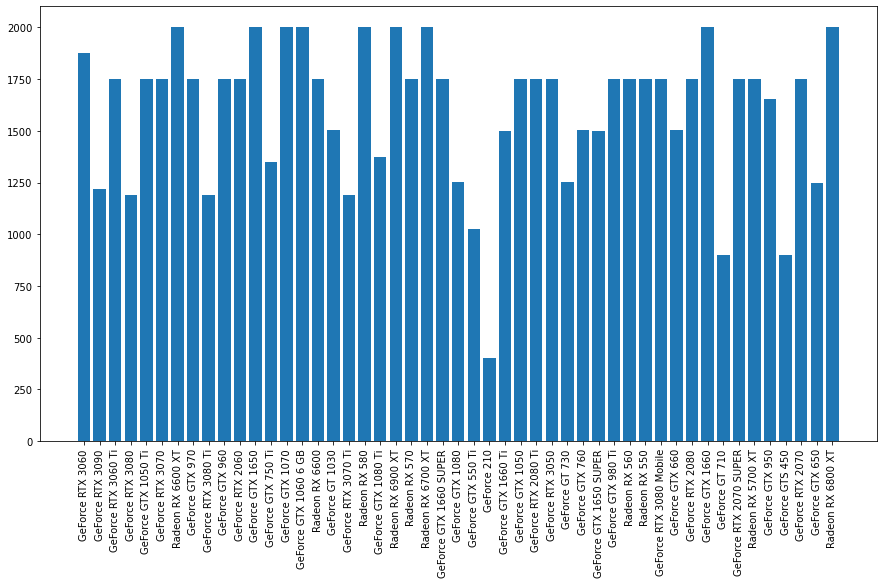

In [33]:
# Have to use astype(Float) since all my measurements are in string type.
plt.figure(figsize=(15, 8))
plt.bar(df["Product Name"], df["Memory clock(MHz)"].astype(float))
plt.xticks(rotation=90)
plt.show()

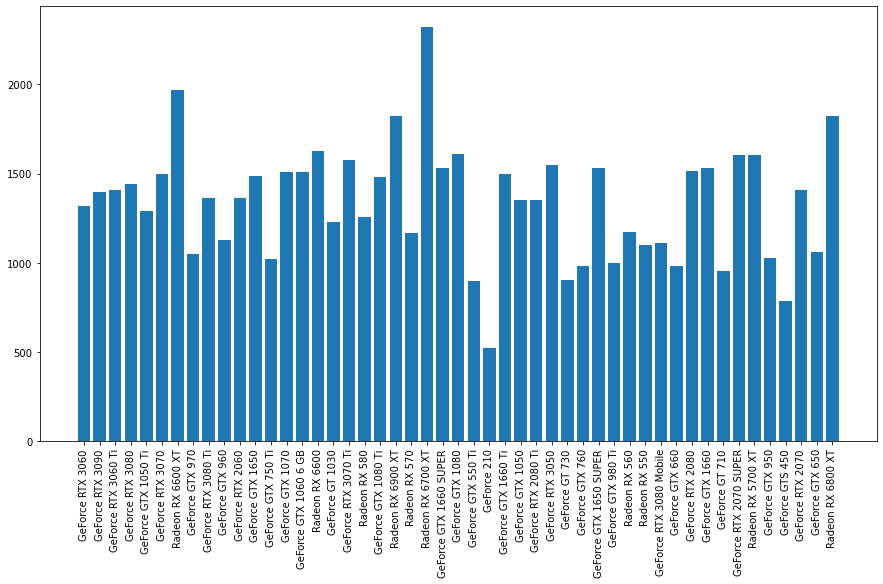

In [34]:
plt.figure(figsize=(15, 8))
plt.bar(df["Product Name"], df["GPU clock(MHz)"].astype(float))
plt.xticks(rotation=90)
plt.show()

In [35]:
fig1 = px.box(df, y= ["Memory clock(MHz)", "GPU clock(MHz)"])
fig1.show()

In [40]:
# Shaders has too much variance, and it makes the box plot look really can't see TMU or ROPs
#fig2 = px.box(df, y =["Shaders", "TMUs", "ROPs"])
fig2 = px.box(df, y =["TMUs", "ROPs"])
fig2.show()

In [36]:
df.skew()

Shaders              1.728294
TMUs                 0.866194
ROPs                 0.561571
GPU clock(MHz)       0.219664
Memory clock(MHz)   -1.212406
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x279BA5E0>,
      dtype=object)

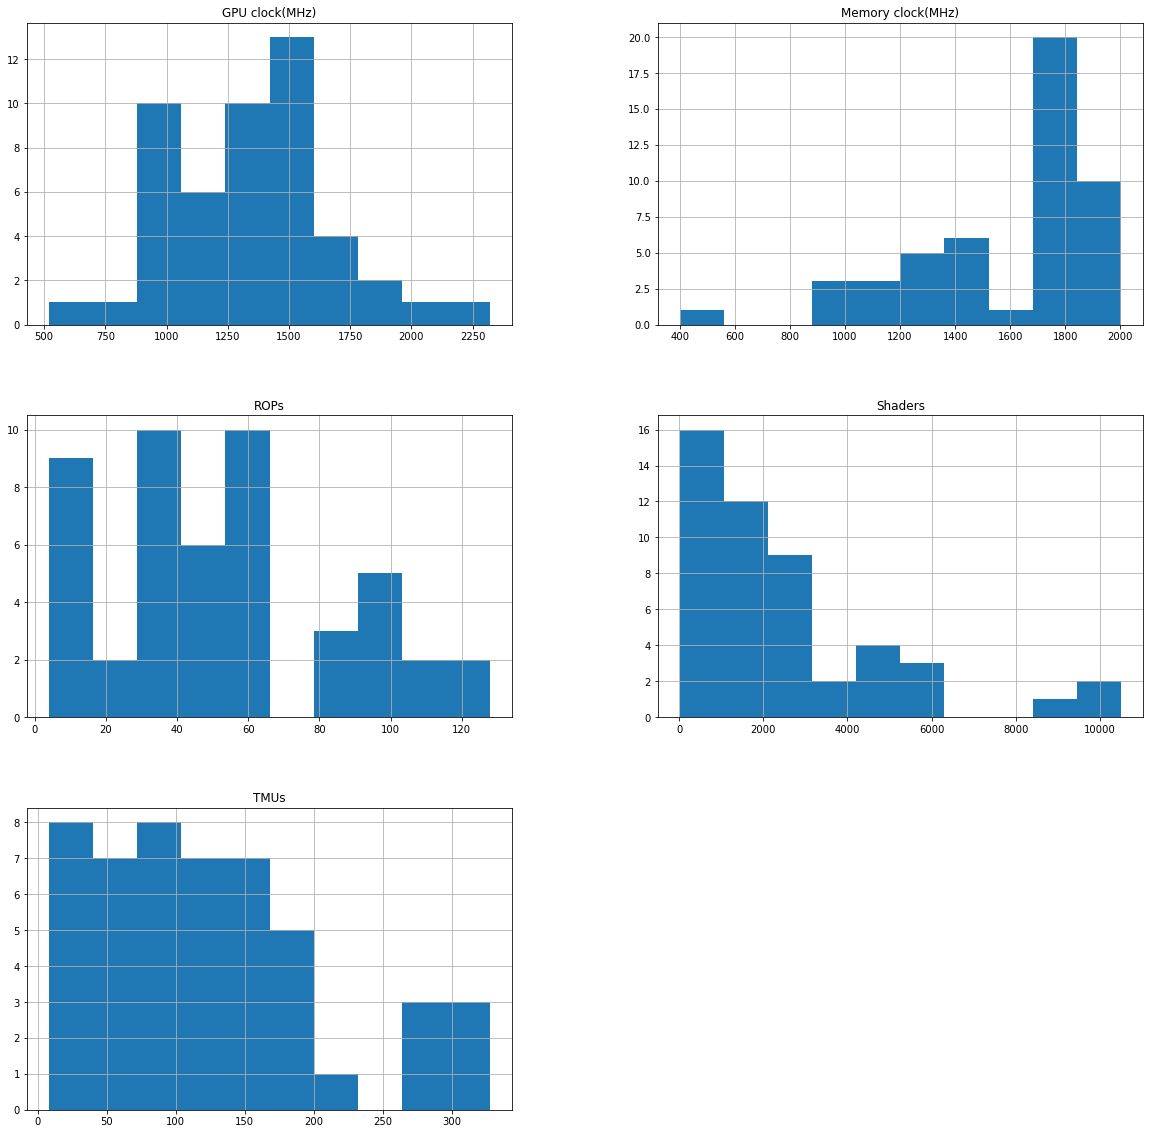

In [42]:
df.hist(figsize=(20,20))

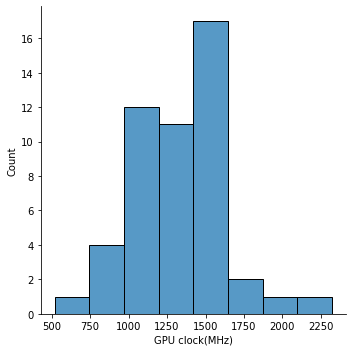

In [46]:
sns.displot(df['GPU clock(MHz)'])

In [ ]:
fig = px.pie(df, values=df['Bus'], names=df['Bus'].index, title='Population of European continent')
fig.show()

In [17]:
df["Released"].str.split(' ', expand=True)

,0,1,2
0,Jan,"12th,",2021
1,Sep,"1st,",2020
2,Dec,"1st,",2020
3,Sep,"1st,",2020
4,Oct,"25th,",2016
5,Sep,"1st,",2020
6,Jul,"30th,",2021
7,Sep,"19th,",2014
8,May,"31st,",2021
9,Jan,"22nd,",2015


In [18]:
for i in df["Released"].str.split(' ', expand=True)[2]:
    if i == None:
        continue
    else:
        print(i)

2021
2020
2020
2020
2016
2020
2021
2014
2021
2015
2019
2019
2014
2016
2016
2021
2017
2021
2017
2017
2020
2017
2021
2019
2016
2011
2009
2019
2016
2018
2014
2013
2019
2015
2017
2017
2021
2012
2018
2019
2014
2019
2019
2015
2010
2018
2012
2020


In [22]:
df["Released"].str.split(' ', expand=True).head()

,0,1,2
0,Jan,"12th,",2021
1,Sep,"1st,",2020
2,Dec,"1st,",2020
3,Sep,"1st,",2020
4,Oct,"25th,",2016


In [20]:
# If bus is PCIe = 4.0 x 16, then we know its a relatively modern and competible GPU

In [21]:
# logistic, KNN or clustering for determing which gpu is modern/relevant 
# Maybe implement a 

In [11]:
model = LogisticRegression(solver='liblinear', random_state=0)